In [25]:
data_salvar_modelo = '220623_classificacao_clorofila_eua'

In [26]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
from collections import Counter
import random
#!pip3 install pickle5
#import pickle5 as pickle
import pickle
import glob

%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use('ggplot')
plt.rcParams["axes.grid"] = False

from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#!pip install imblearn
from  imblearn.under_sampling  import  CondensedNearestNeighbour
from imblearn.under_sampling import TomekLinks
# https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/

In [27]:
# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
data = pd.read_excel('4647_dataset_clorofila_classif_iqar.xlsx')
df_mask = data['Dominio'] == 'Estados_Unidos'
data = data[df_mask]
df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Classe']]
df['Classe'] = df['Classe'] - 1
df

,BAND_1,BAND_2,BAND_3,BAND_4,BAND_5,BAND_6,BAND_7,BAND_8,BAND_8A,BAND_9,BAND_11,BAND_12,Classe
0,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
1,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
2,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
3,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
4,31.0,51,16,1,1,1,1.0,1,1.0,1.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4250,2354.0,3377,3374,3267,3581,3857,3978.0,4320,4081.0,3659.0,3620,3277,0
4267,3416.0,3987,3919,3772,4162,4941,5198.0,5331,5291.0,5848.0,4112,3400,0
4268,3416.0,3987,3919,3772,4162,4941,5198.0,5331,5291.0,5848.0,4112,3400,1
4324,4043.0,5094,4724,4466,4746,5105,5109.0,5666,5066.0,6588.0,4550,3784,5


In [28]:
# pegar somente amostras com QA60 (pegar <=0) e NUVEM_SOMBRA (pegar diferente de Cloud)
#data = pd.read_excel('4647_dataset_clorofila_classif_iqar.xlsx')
#df_filtro = data.loc[(data['QA60'] <= 0) & (data['NUVEM_SOMBRA'] != 'CLOUD')]
# apagar linhas que contem NaN
#df_filtro = df_filtro.dropna()
# filtrar so para bandas e classe
#df = df_filtro[['BAND_1','BAND_2','BAND_3','BAND_4','BAND_5','BAND_6','BAND_7','BAND_8','BAND_8A','BAND_9','BAND_11','BAND_12','Classe']]
#df

In [29]:
# contar classes
print('Quantidade por classe:')
print(df['Classe'].value_counts())

# filtrar por classe
df_1 = df[df['Classe']==0]
df_2 = df[df['Classe']==1]
df_3 = df[df['Classe']==2]
df_4 = df[df['Classe']==3]
df_5 = df[df['Classe']==4]
df_6 = df[df['Classe']==5]

Quantidade por classe:
4    551
3    376
2    260
5    249
1    233
0    161
Name: Classe, dtype: int64


In [30]:
#separar treino e teste
qtd_amostras_treino = 150

randomlist = random.sample(range(0, df_1.shape[0]), qtd_amostras_treino)
df_1_train = df_1.iloc[randomlist]
df_1_test = df_1.drop(df_1.index[randomlist])

randomlist = random.sample(range(0, df_2.shape[0]), qtd_amostras_treino)
df_2_train = df_2.iloc[randomlist]
df_2_test = df_2.drop(df_2.index[randomlist])

randomlist = random.sample(range(0, df_3.shape[0]), qtd_amostras_treino)
df_3_train = df_3.iloc[randomlist]
df_3_test = df_3.drop(df_3.index[randomlist])

randomlist = random.sample(range(0, df_4.shape[0]), qtd_amostras_treino)
df_4_train = df_4.iloc[randomlist]
df_4_test = df_4.drop(df_4.index[randomlist])

randomlist = random.sample(range(0, df_5.shape[0]), qtd_amostras_treino)
df_5_train = df_5.iloc[randomlist]
df_5_test = df_5.drop(df_5.index[randomlist])

randomlist = random.sample(range(0, df_6.shape[0]), qtd_amostras_treino)
df_6_train = df_6.iloc[randomlist]
df_6_test = df_6.drop(df_6.index[randomlist])

print('Classe 1 - treino:', df_1_train.shape[0], '/ teste:', df_1_test.shape[0])
print('Classe 2 - treino:', df_2_train.shape[0], '/ teste:', df_2_test.shape[0])
print('Classe 3 - treino:', df_3_train.shape[0], '/ teste:', df_3_test.shape[0])
print('Classe 4 - treino:', df_4_train.shape[0], '/ teste:', df_4_test.shape[0])
print('Classe 5 - treino:', df_5_train.shape[0], '/ teste:', df_5_test.shape[0])
print('Classe 6 - treino:', df_6_train.shape[0], '/ teste:', df_6_test.shape[0])

Classe 1 - treino: 150 / teste: 11
Classe 2 - treino: 150 / teste: 83
Classe 3 - treino: 150 / teste: 110
Classe 4 - treino: 150 / teste: 226
Classe 5 - treino: 150 / teste: 401
Classe 6 - treino: 150 / teste: 99


In [31]:
# concatenar dataframes
frames_train = [df_1_train, df_2_train, df_3_train, df_4_train, df_5_train, df_6_train]
df_train = pd.concat(frames_train)
frames_test = [df_1_test, df_2_test, df_3_test, df_4_test, df_5_test, df_6_test]
df_test = pd.concat(frames_test)
#print('Tamanho train:', df_train.shape)
#print('Tamanho test:', df_test.shape)

# separar entrada e rotulo do treino e teste
X_train = df_train.to_numpy()[:,:12]
y_train = df_train.to_numpy()[:,12].astype(int)
X_test = df_test.to_numpy()[:,:12]
y_test = df_test.to_numpy()[:,12].astype(int)

print('Tamanho train:', X_train.shape, '/ rotulos:', y_train.shape)
print('Tamanho test:', X_test.shape, '/ rotulos:', y_test.shape)

Tamanho train: (900, 12) / rotulos: (900,)
Tamanho test: (930, 12) / rotulos: (930,)


In [32]:
#padronizando dados antes do treinamento
scaler = StandardScaler()

norm_X_train = scaler.fit_transform(X_train)
norm_X_test = scaler.transform(X_test)

# Naive Bayes

Melhores hiperparametros do modelo: {'var_smoothing': 0.001}

Acuracia:  0.3258064516129032
              precision    recall  f1-score   support

           0       0.05      0.18      0.08        11
           1       0.04      0.02      0.03        83
           2       0.17      0.05      0.07       110
           3       0.26      0.05      0.09       226
           4       0.45      0.60      0.51       401
           5       0.19      0.43      0.26        99

    accuracy                           0.33       930
   macro avg       0.19      0.22      0.17       930
weighted avg       0.30      0.33      0.28       930



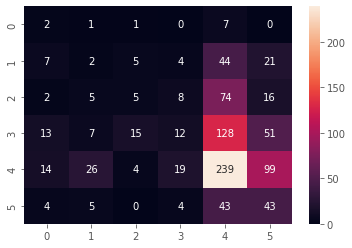

In [33]:
#treinar naive bayes

# pesquisa em grade
param_grid_nb = {'var_smoothing': [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12, 1e-13, 1e-14, 1e-15]}

grid_nb = GridSearchCV(GaussianNB(),param_grid_nb,refit=True)
grid_nb.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_nb.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_nb, open(data_salvar_modelo+'_nb.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_nb_predictions = grid_nb.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_nb_predictions))
#print(confusion_matrix(y_teste,grid_nb_predictions))
print(classification_report(y_test, grid_nb_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_nb_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

# SVM

Melhores hiperparametros do modelo: {'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}

Acuracia:  0.44408602150537635
              precision    recall  f1-score   support

           0       0.05      0.45      0.09        11
           1       0.24      0.53      0.33        83
           2       0.36      0.35      0.35       110
           3       0.40      0.31      0.35       226
           4       0.73      0.48      0.58       401
           5       0.57      0.64      0.60        99

    accuracy                           0.44       930
   macro avg       0.39      0.46      0.39       930
weighted avg       0.54      0.44      0.47       930



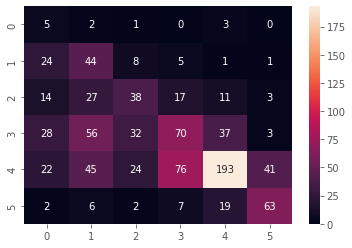

In [34]:
# treinar svm

# pesquisa em grade
param_grid_svm = {'C': [0.1,1, 10, 100,1000], 
                  'gamma': [1,0.1,0.01,0.001,0.0001], 
                  'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

grid_svm = GridSearchCV(SVC(),param_grid_svm,refit=True, n_jobs=-1)
grid_svm.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_svm.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_svm, open(data_salvar_modelo+'_svm.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'svm.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_svm_predictions = grid_svm.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_svm_predictions))
#print(confusion_matrix(y_teste,grid_svm_predictions))
print(classification_report(y_test, grid_svm_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_svm_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

# Random Forest

In [ ]:
#treinar random forest

# pesquisa em grade
param_grid_rf = {'bootstrap': [True, False], 
            'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
            'max_features': ['auto', 'sqrt'], 
            'min_samples_leaf': [1, 2, 4], 
            'min_samples_split': [2, 5, 10],
            'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}

grid_rf = GridSearchCV(RandomForestClassifier(),param_grid_rf,refit=True, n_jobs=-1)
grid_rf.fit(norm_X_train,y_train)

print('Melhores hiperparametros do modelo:', grid_rf.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_rf, open(data_salvar_modelo+'_rf.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_rf_predictions = grid_rf.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test, grid_rf_predictions))
#print(confusion_matrix(y_teste,grid_rf_predictions))
print(classification_report(y_test, grid_rf_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_rf_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')

# XGBoost

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.preprocessing import StandardScaler
plt.style.use('ggplot')
from collections import Counter
import random
#!pip3 install pickle5
#import pickle5 as pickle
import pickle
import glob
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
#!pip install xgboost==0.90
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

In [ ]:
#treinar xgboost

# pesquisa em grade
param_grid_xgb = { 'min_child_weight': [1, 5, 10], 
                  'gamma': [0.5, 1, 1.5, 2, 5], 
                  'subsample': [0.6, 0.8, 1.0], 
                  'colsample_bytree': [0.6, 0.8, 1.0], 
                  'n_estimators': [400, 500, 600, 700], 
                  'learning_rate': [0.1, 0.01, 0.001],
                  'max_depth': [3, 4, 5] }

grid_xgb = GridSearchCV(XGBClassifier(objective='binary:logistic', 
                                      silent=True, nthread=1, verbosity = 0, 
                                      use_label_encoder=False),
                        param_grid_xgb, refit=True, verbose=True, n_jobs=-1)

le = LabelEncoder()
y_train = le.fit_transform(y_train)

grid_xgb.fit(norm_X_train,y_train.astype(int))

print('Melhores hiperparametros do modelo:', grid_xgb.best_params_)

#################################

# salvar o modelo no disco
pickle.dump(grid_xgb, open(data_salvar_modelo+'_xgb.pkl', 'wb'))

# carregar o modelo salvo em disco
#loaded_model = pickle.load(open(data_salvar_modelo+'rf_com_cluster.pkl', 'rb'))
#result = loaded_model.score(norm_X_teste_com_cluster, y_teste)
#print(result)

#################################

# testar
grid_xgb_predictions = grid_xgb.predict(norm_X_test)
print('\nAcuracia: ', accuracy_score(y_test.astype(int), grid_xgb_predictions))
#print(confusion_matrix(y_teste,grid_xgb_predictions))
print(classification_report(y_test.astype(int), grid_xgb_predictions))

# matrix de confusao
cm = confusion_matrix(y_test, grid_xgb_predictions)
f = sns.heatmap(cm, annot=True, fmt='d')